## Model evaluation

### Binary classification: negative or postive

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

In [ ]:
include("reporting.jl")
include("utilities.jl")
include("training.jl")

update_history! (generic function with 1 method)

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [ ]:
path = "datasets\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

filtered

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20230627_2032"

saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => BytePairEncoder{String}(length(rules)=8000, length(cache)=0, un…
  :indexer   => IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 1),                       # 51 parameters
)        # Total: 21 trainable arrays, 251_348 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.083 MiB.

In [ ]:
max_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents)
@time indices = indexer(tokens) 

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = reshape(y_train, 1, :)
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 41.152046 seconds (654.76 M allocations: 17.243 GiB, 7.98% gc time, 1.46% compilation time)
 15.997686 seconds (56.55 k allocations: 80.689 MiB, 0.28% gc time, 0.37% compilation time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [ ]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

documents_test_sub = documents_test[idxs]
X_test = indices_test[:, idxs]

println("test documents: ", size(documents_test_sub))
println("test samples: ", size(X_test), " ", size(y_test))

  0.824357 seconds (6.00 M allocations: 181.317 MiB, 14.79% gc time, 8.80% compilation time)
  0.419365 seconds (4 allocations: 1.946 MiB)
test documents: (4000,)
test samples: (50, 4000) (1, 4000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.logitbinarycrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean((Flux.sigmoid.(ŷ) .> 0.5) .== y)

accuracy (generic function with 1 method)

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

 57.211074 seconds (40.32 M allocations: 45.910 GiB, 8.79% gc time, 26.52% compilation time)


0.9138194444444444

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  4.819891 seconds (92.50 k allocations: 4.883 GiB, 9.35% gc time)


0.875375

In [ ]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.33389, 0.29097, 0.274802, 0.260442, 0.250043, 0.240717,…
  "train_acc"  => Any[0.853889, 0.876, 0.883854, 0.890618, 0.896437, 0.901021, …
  "val_acc"    => Any[0.847187, 0.866187, 0.870563, 0.874062, 0.874563, 0.87743…
  "val_loss"   => Any[0.34411, 0.310354, 0.300017, 0.295991, 0.295273, 0.291249…

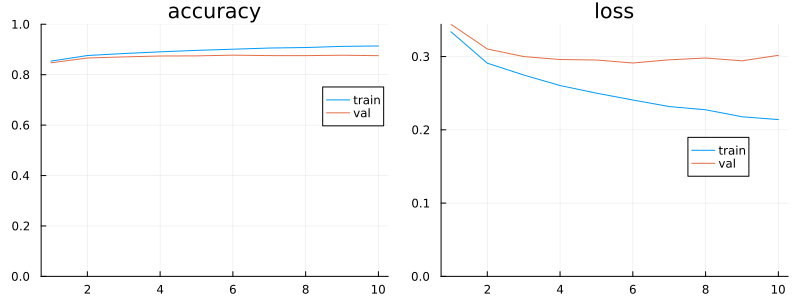

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.872

In [ ]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [ ]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1781   219
  293  1707

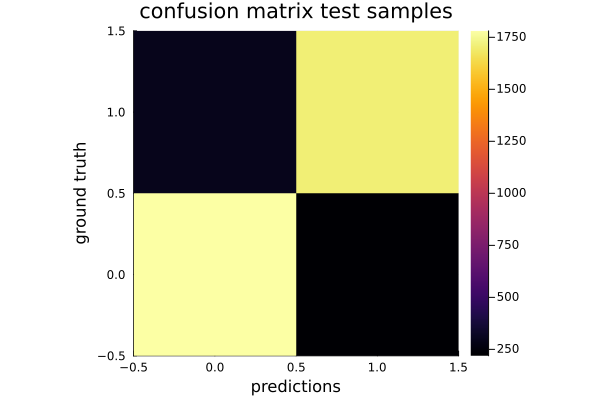

In [ ]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [ ]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.86    0.89      0.87     2000
           1       0.89    0.85      0.87     2000

weighted avg       0.87    0.87      0.87     4000

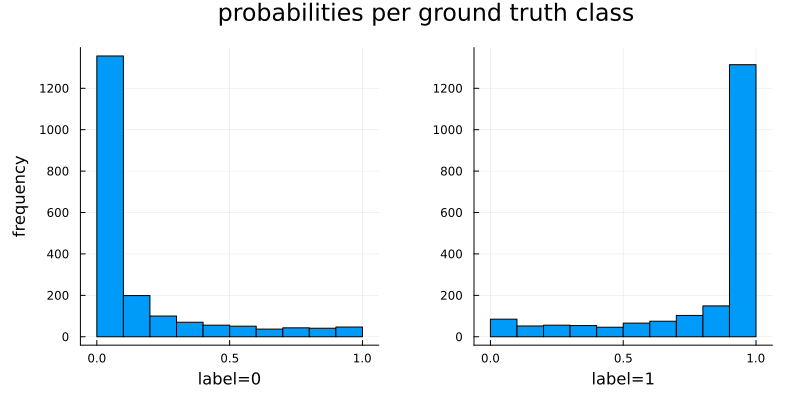

In [ ]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [ ]:
pos_max = argmax(probs)[2]
pos_min = argmin(probs)[2]

println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
3164  1  1  0.9999  Love it exactly what I needed good quality
 444  0  0  0.0003  I never received my order very disappointing!!


In [ ]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, y_test[idx], y_pred[idx], probs[idx], documents_test_sub[idx]
            )
        end
    end
    println("")
end

correct: 1781 / 2000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
1277  0  0  0.0520  The download for this software is available for free elsewhere
----------------------------------------------------------------------------------------------------
1509  0  0  0.0675  I love these shelves but I was pissed when I went to put them up. The metal washer covers don't fit over all the plastic washer. So, I was stuck leaving the ugly black plastic washers showing. Very upsetting. You can't tell this at first glance either unless you physically put the washers inside of a metal piece.
----------------------------------------------------------------------------------------------------
1594  0  0  0.1118  I ordered the Pro-Team Vacuum Cleaner and the suggested bags the the advertisement. The bags are the wrong size. Can I return them or am I stuck with what I ordered. Thank you, Curtis White
---------------------------

## Test data including star=3

In [ ]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

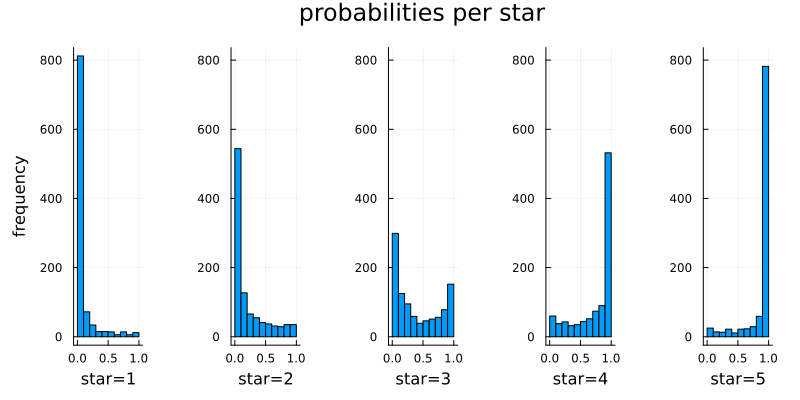

In [ ]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [ ]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    println("-"^100)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

star = 3
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
2527  3  0  0.2947  Im giving it 3 stars for now, i don't want leave a bad review for the seller unless he deserves it but this drone overheats a lot. Im not sure if i should contact the seller or dji tello themselves but ill probably try both just to see what they say. I like the drone is a cool little toy that fly's better than some bigger older drones and some of my bigger drones feel more like a toy than this one. However its the only drone i have ever had overheating issues with and it actually takes the fun out of flying im going to assume for now that its a manufacturing issue which they need to address asap if they want there product to be successful. I really hope the seller did not send me a use drone as i paid for a new one. I will give the sellers props for delivery as it arrive 1 day after purchase. I will update date my review after contacting

## Single samples

In [ ]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.
⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series|⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one|⋅loved|⋅them|⋅all|⋅al|##ask|##an|⋅nights|⋅was|⋅awesome|⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman|⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending|⋅have|⋅read|⋅two|⋅other|⋅books
8|242|306|2|475|633|5068|985|2849|44|28|2|167|27|235|32|37|1647|6812|985|2849|14|476|2962|11|1759|403|831|3469|347|2966|1578|269|1998|1521|17|4949|3152|4805|3813|2152|1626|137|124|1537|18|175|106|79|553


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
 -0.578869    -0.139377    2.00418   …   0.807568    1.5264     -0.748737
 -0.318301     0.111475    2.24222      -0.878201    0.138046    0.338547
 -0.593076     0.194876    1.03162      -0.0236239  -0.523535    1.63805
  0.458524     0.244169    0.652872     -1.4617     -1.17621     0.361062
  0.84622     -0.985024    1.228         0.370744    1.06486    -0.261807
 -1.8476      -0.615427    0.327171  …   0.428301   -0.965649    0.600132
 -0.208327    -0.279854    0.55833       1.42127    -1.71655     1.253
 -1.65261     -0.86928    -0.658181     -0.809366   -1.42481     1.6159
 -0.721565     0.2058      0.618696     -1.04925    -2.44127     1.90579
  0.566393    -0.944485    0.827048     -1.24412     0.186316   -0.519677
  1.04468      0.0101439   0.3553    …  -1.39299     1.0174     -0.133086
  0.00109146   0.842851   -0.551782     -0.708992   -1.59494    -1.80965
  0.420413    -0.568329    0.169467     -0.409061   -0.915224   -0.689318
  ⋮                    

In [ ]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.9979504